## Toxic comment classification
### Import library

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gc

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import log_loss,confusion_matrix,classification_report,roc_curve,auc

import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from scipy import sparse
%matplotlib inline
seed = 42
import os
os.environ['OMP_NUM_THREADS'] = '4'


## Read data set

In [3]:
#path = 'file/'
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
print('Number of rows and columns in the train data set:',train.shape)
print('Number of rows and columns in the test data set:',test.shape)

Number of rows and columns in the train data set: (159571, 8)
Number of rows and columns in the test data set: (153164, 2)


In [4]:
raw_train = train

In [5]:
train = train.sample(5000)
#train[train['toxic']==1].values[:5]

In [7]:
raw_test = test

In [8]:
test = test.sample(5000)

## Target varaible distribution

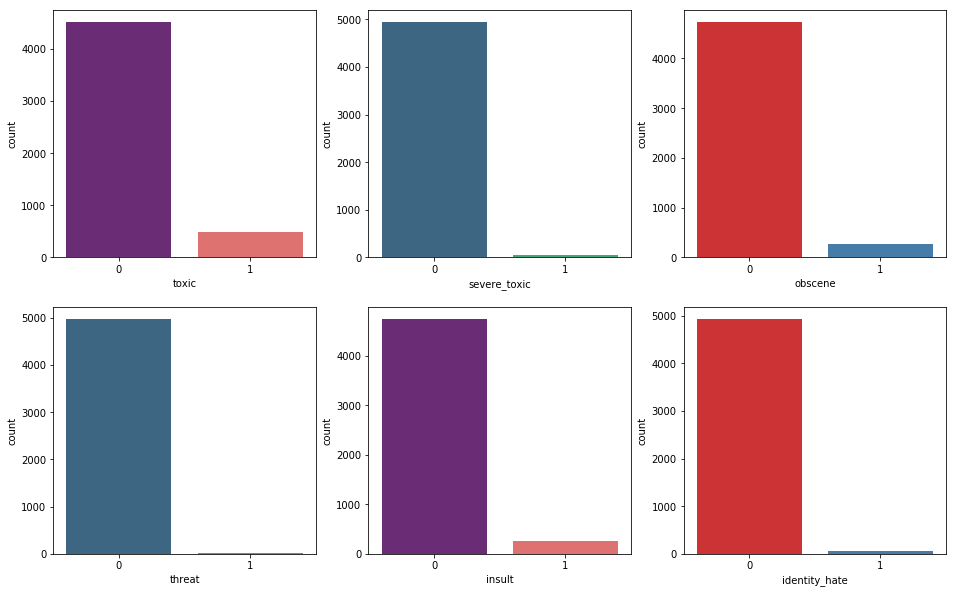

In [10]:
fig,ax = plt.subplots(2,3,figsize=(16,10))
ax1,ax2,ax3,ax4,ax5,ax6 = ax.flatten()
sns.countplot(train['toxic'],palette= 'magma',ax=ax1)
sns.countplot(train['severe_toxic'], palette= 'viridis',ax=ax2)
sns.countplot(train['obscene'], palette= 'Set1',ax=ax3)
sns.countplot(train['threat'], palette= 'viridis',ax = ax4)
sns.countplot(train['insult'], palette = 'magma',ax=ax5)
sns.countplot(train['identity_hate'], palette = 'Set1', ax = ax6);

## Missing value

In [11]:
k = pd.DataFrame()
k['train'] = train.isnull().sum()
k['test'] = test.isnull().sum()
k

,train,test
id,0,0.0
comment_text,0,0.0
toxic,0,NaN
severe_toxic,0,NaN
obscene,0,NaN
threat,0,NaN
insult,0,NaN
identity_hate,0,NaN


In [12]:
test[test['comment_text'].isnull()]

,id,comment_text


In [13]:
test.fillna(' ',inplace=True)
gc.collect()

86

## Text preprosesing

[source: ](https://www.kaggle.com/him4318/easy-and-fast-lb-044) 

Term Frequency Inverse Document  Frequency Vectorizer 

In [27]:
vect_word = TfidfVectorizer(max_features=20000, lowercase=True, analyzer='word',
                        stop_words= 'english',ngram_range=(1,3),dtype=np.float32)
vect_char = TfidfVectorizer(max_features=40000, lowercase=True, analyzer='char',
                        stop_words= 'english',ngram_range=(3,6),dtype=np.float32)

In [29]:
# Word ngram vector
tr_vect = vect_word.fit_transform(train['comment_text'])
ts_vect = vect_word.transform(test['comment_text'])

# Character n gram vector
tr_vect_char = vect_char.fit_transform(train['comment_text'])
ts_vect_char = vect_char.transform(test['comment_text'])
#gc.collect()

In [32]:
incel_df = pd.read_csv('new_IncelTears_posts.csv')

In [16]:
X = sparse.hstack([tr_vect, tr_vect_char])
x_test = sparse.hstack([ts_vect, ts_vect_char])

In [17]:
target_col = ['toxic', 'severe_toxic', 'obscene', 'threat','insult', 'identity_hate']
y = train[target_col]
del tr_vect, ts_vect, tr_vect_char, ts_vect_char
gc.collect()

40

## Model

In [18]:
prd = np.zeros((x_test.shape[0],y.shape[1]))
cv_score =[]
for i,col in enumerate(target_col):
    lr = LogisticRegression(C=2,random_state = i,class_weight = 'balanced')
    print('Building {} model for column:{''}'.format(i,col)) 
    lr.fit(X,y[col])
    #cv_score.append(lr.score)
    prd[:,i] = lr.predict_proba(x_test)[:,1]

Building 0 model for column:toxic


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Building 1 model for column:severe_toxic
Building 2 model for column:obscene
Building 3 model for column:threat
Building 4 model for column:insult
Building 5 model for column:identity_hate


## Model Validation on train data set

In [21]:
col = 'identity_hate'
print("Column:",col)
pred =  lr.predict(X)
print('\nConfusion matrix\n',confusion_matrix(y[col],pred))
print(classification_report(y[col],pred))

Column: identity_hate

Confusion matrix
 [[4931   11]
 [   0   58]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4942
           1       0.84      1.00      0.91        58

   micro avg       1.00      1.00      1.00      5000
   macro avg       0.92      1.00      0.96      5000
weighted avg       1.00      1.00      1.00      5000



## Roc AUC curve

In [ ]:
col = 'identity_hate'
print("Column:",col)
pred_pro = lr.predict_proba(X)[:,1]
frp,trp,thres = roc_curve(y[col],pred_pro)
auc_val =auc(frp,trp)
plt.figure(figsize=(14,10))
plt.plot([0,1],[0,1],color='b')
plt.plot(frp,trp,color='r',label= 'AUC = %.2f'%auc_val)
plt.legend(loc='lower right')
plt.xlabel('True positive rate')
plt.ylabel('False positive rate')
plt.title('Reciever Operating Characteristic')

## submission